In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Imports

In [2]:
# ! pip install pycountry

In [3]:
import random

from collections import Counter
import pycountry    # To normalize the location field.

# Reading the data

In [4]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# EDA

## Looking at the csv file

Columns:

* id - a unique identifier for each tweet
* keyword - a particular keyword from the tweet (may be blank)
* location - the location the tweet was sent from (may be blank)
* text - the text of the tweet
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [5]:
train_data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Be careful while displaying the df - might print the whole df when saving - use head instead

## Check datatypes of the columns

In [6]:
train_data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Length of the training and test data

In [7]:
print('The length of the training data is %d' % len(train_data))
print('The length of the test data is %d' % len(test_data))

The length of the training data is 7613
The length of the test data is 3263


In [8]:
len(train_data) + len(test_data)

10876

## Number of NAN values in the columns

In [9]:
train_data.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

Suggestions:

In [10]:
train_data.isna().sum()/len(train_data)*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Most of the times look at fractions of the totals rather than totals - What is the fraction of the location values that are missing? Fractions are useful...!

In [11]:
7613 - 7552

61

#### NAN values in the location column

In [12]:
7613 - 5080

2533

## Average number of characters in the text column

In [13]:
num_char_series = train_data['text'].str.len()
num_char_series.mean()

101.03743596479706

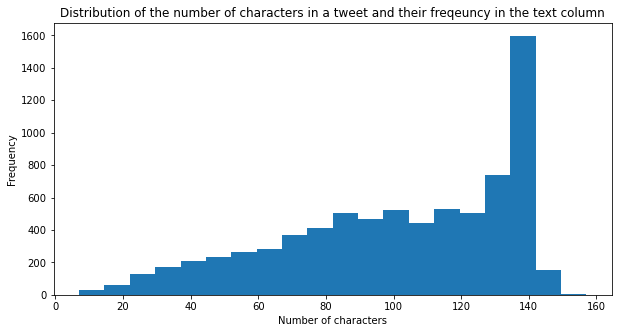

In [14]:
ax = num_char_series.plot.hist(bins=20, figsize=(10,5))
ax.set_xlabel("Number of characters")
ax.set_ylabel("Frequency")
_ = ax.set_title('Distribution of the number of characters in a tweet and their freqeuncy in the text column')

Why the huge peak at 130-140?

Max limit by Twitter: 280 characters now - earlier it was 140 and that can be a reason of the spike.

## Average number of words in the text column
Note: The average number of words are not expected to be precise as the words are extracted with a naive approach of splitting using the whitespace character.

In [15]:
num_words_series = train_data['text'].str.split().map(len)
num_words_series.mean()

14.903585971364771

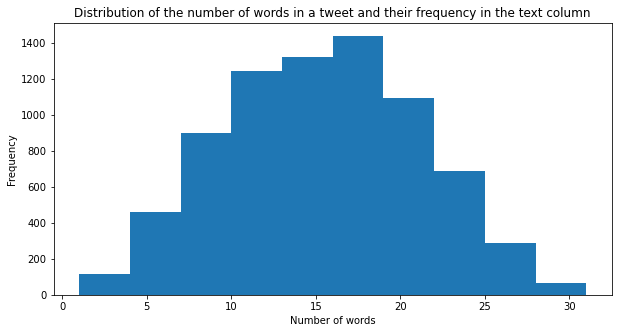

In [16]:
ax = num_words_series.plot.hist(bins=10, figsize=(10,5))
ax.set_xlabel("Number of words")
ax.set_ylabel("Frequency")
_ = ax.set_title('Distribution of the number of words in a tweet and their frequency in the text column')

## Unique values in the keyword column

In [17]:
len(train_data['keyword'].unique())

222

The one different value here is NAN as compared to the count found below.

In [18]:
keyword_value_counts = train_data['keyword'].value_counts()
keyword_value_counts

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [19]:
len(keyword_value_counts)

221

## Is the keyword from the text?

In [20]:
len(train_data)

7613

In [21]:
train_data_keyword_text = train_data[['keyword', 'text']]
len(train_data_keyword_text)

7613

In [22]:
train_data_keyword_text_no_na = train_data_keyword_text.dropna()

In [23]:
len(train_data_keyword_text_no_na)

7552

In [24]:
train_data_keyword_text_no_na['keyword_from_text'] = [x[0].lower() in x[1].lower() for x in zip(train_data_keyword_text_no_na['keyword'], train_data_keyword_text_no_na['text'])]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
train_data_keyword_text_no_na['keyword_from_text'].value_counts(normalize=True)

True     0.790916
False    0.209084
Name: keyword_from_text, dtype: float64

In [26]:
train_data_keyword_text_no_na

,keyword,text,keyword_from_text
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,True
32,ablaze,We always try to bring the heavy. #metal #RT h...,False
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,True
34,ablaze,Crying out for more! Set me ablaze,True
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,True
...,...,...,...
7578,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both,True
7579,wrecked,Three days off from work and they've pretty mu...,True
7580,wrecked,#FX #forex #trading Cramer: Iger's 3 words tha...,True
7581,wrecked,@engineshed Great atmosphere at the British Li...,True


In [27]:
train_data_keyword_text_no_na['text'].iloc[1]

'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw'

The keyword ablaze is not present in the text...!

In [28]:
train_data_keyword_text_no_na['text'].iloc[4]

'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N'

The keyword ablaze is present in the text...!

## Exploring the text field

In [29]:
random_indices = random.sample(range(len(train_data)), 20)
random_indices[:5]

[7055, 691, 4158, 1527, 35]

In [30]:
for i in random_indices:
    print(i, train_data['text'].iloc[i])

7055 Buddha was 'man for his time' - massive urbanisation and social upheaval also challenged Brahmans dominance ('Genius of the Ancient World').
691 SHOUOUT TO @kasad1lla CAUSE HER VOCALS ARE BLAZING HOT LIKE THE WEATHER SHES IN
4158 @angel_star39 Obama should feel responsible bringing in these illegals He- his family well protected from harm. No feeling or heart 4 others
1527 Emergency Response and Hazardous Chemical Management: Principles and Practices http://t.co/4sSuyhkgRB http://t.co/TDerBtgZ2k
35 On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N
1981 Cyclone by Double G would be the cherry on top to this outfit! #OOTD #DoubleGhats http://t.co/JSuHuPz6Vp http://t.co/N5vrFFRbo3
1452 Social Casualty #MTVHottest 5SOS
818 I really wants a rolo blizzard but mom said no so I guess no DQ tonight
1923 ExOfficio Men's Boxer Brief Curfew Large http://t.co/acb0ryeNuo
2937 Visting Georgina at The Drowned Rat Cafe.....awful view!! http://t.co/pYLFb3tI9U
96 Has an ac

In [31]:
for i in random_indices:
    print(i, train_data['target'].iloc[i])

7055 0
691 0
4158 0
1527 0
35 0
1981 0
1452 0
818 0
1923 0
2937 1
96 0
2834 0
1485 1
5406 0
2123 0
1700 0
4628 0
5109 1
53 1
5977 0


Comments:
* Check whether the labels are correct.
* Read the tweets and compare them with the targets.

## Exploring the location field

In [32]:
train_data['location'].isna().sum()/len(train_data)*100

33.27203467752528

Around 33.27% data has NaN values / is missing in the location column.

In [33]:
train_data['location'].value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
Lurking                         1
Penn Hills, PA                  1
Suburban Detroit, Michigan      1
Montana, USA                    1
planet earth                    1
Name: location, Length: 3341, dtype: int64

This field is not normalized.

In [34]:
city, province 

NameError: name 'city' is not defined

In [35]:
def normalize_area_names(area):
    if not pd.isnull(area):
        if ',' in area:
            country = pycountry.countries.search_fuzzy(area.rsplit(',', 1)[1])
            return country
        else:
            try:
                country = pycountry.countries.search_fuzzy(area)
            except:
                for sub_area in area.split():
                    try:
                        country = pycountry.countries.search_fuzzy(area)
                        break
                    except:
                        print(sub_area)
                        print('Lookup error')
                        continue
            return country
    else:
        return area

Comments:

* Does the location field matter here?


* This can be delayed because it might not help very much in the actual task of detecting the tweet as containing disaster or not.

In [36]:
est. september 2012 - bristol

SyntaxError: invalid syntax (<ipython-input-36-17395d17d6ac>, line 1)

In [37]:
x = 'testtest'
try:
    country = pycountry.countries.search_fuzzy(x)
except:
    print('tes')

tes


In [38]:
train_data['location'].apply(lambda x: normalize_area_names(x)).value_counts()

Est.
Lookup error
September
Lookup error
2012
Lookup error
-
Lookup error
Bristol
Lookup error


UnboundLocalError: local variable 'country' referenced before assignment

In [39]:
pycountry.countries.search_fuzzy('bristol')

[Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')]

In [40]:
pycountry.countries.search_fuzzy('New Mexico')

[Country(alpha_2='US', alpha_3='USA', name='United States', numeric='840', official_name='United States of America')]

Day 1 discussion:
Christian:

* Wrote the business goal section.



Thoughts:
* Can create a world map that shows where the tweets are from.

Day 2 discussion:

Thoughts:

Features:
1. A feature with how many capital characters are present in the text?
2. How many special characters are present in the text?
3. Features - contains url?